In [1]:
# Konfigurasi Spark
import os
import sys

# 1. Mengeset variabel yang menyimpan lokasi di mana Spark diinstal
spark_path = "C:/spark"

# 2. Menentukan environment variable SPARK_HOME
os.environ['SPARK_HOME'] = spark_path

# 3. Simpan lokasi winutils.exe sebagai environment variable HADOOP_HOME
os.environ['HADOOP_HOME'] = spark_path

# 4. Lokasi Python yang dijalankan --> punya Anaconda
#    Apabila Python yang diinstall hanya Anaconda, maka tidak perlu menjalankan baris ini.
os.environ['PYSPARK_PYTHON'] = sys.executable

# 5. Konfigurasi path library PySpark
sys.path.append(spark_path + "/bin")
sys.path.append(spark_path + "/python")
sys.path.append(spark_path + "/python/pyspark/")
sys.path.append(spark_path + "/python/lib")
sys.path.append(spark_path + "/python/lib/pyspark.zip")
sys.path.append(spark_path + "/python/lib/py4j-0.10.4-src.zip")

# 6. Import library Spark
#    Dua library yang WAJIB di-import adalah **SparkContext** dan **SparkConf**.
from pyspark import SparkContext
from pyspark import SparkConf

# Setting konfigurasi (opsional)
conf = SparkConf()
conf.set("spark.executor.memory", "2g")
conf.set("spark.cores.max", "4")

sc = SparkContext("local", conf=conf)
#    Apabila berhasil, maka ketika sc di-print akan mengeluarkan nilai <pyspark.context.SparkContext object>
print sc


In [2]:
from numpy import array
from math import sqrt
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyspark.mllib.clustering import KMeans, KMeansModel

In [3]:
# Make the graphs a bit prettier, and bigger
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

C:\ProgramData\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
na_values = ['NO CLUE', 'N/A', '0', 0]
filepath = 'data/scrubbed.csv';
data = pd.read_csv(filepath,  na_values=na_values);

C:\ProgramData\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
clean_data = data[data['latitude'].astype(str).str.match('^[-+]?[0-9]*\.?[0-9]+$') > 0]

In [6]:
clean_data = clean_data[clean_data['latitude'].astype(str).str.match('^[-+]?[0-9]*\.?[0-9]+$') > 0]

In [7]:
location_data = zip(clean_data['latitude'].astype(float), clean_data['longitude '].astype(float))

In [8]:
# Convert collection to RDD

location_data = sc.parallelize(location_data)

In [9]:
clusters = KMeans.train(location_data, 5, maxIterations=10, initializationMode="random")

In [10]:
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

In [11]:
WSSSE = location_data.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

Within Set Sum of Squared Error = 763147.333189


In [12]:
clusterData = location_data.map(clusters.predict)
label = clusterData.collect()
locationDataCollection = location_data.collect()
locationDataWithLabel = map(lambda(i,x): array([x[0], x[1], label[i]]), enumerate(locationDataCollection))

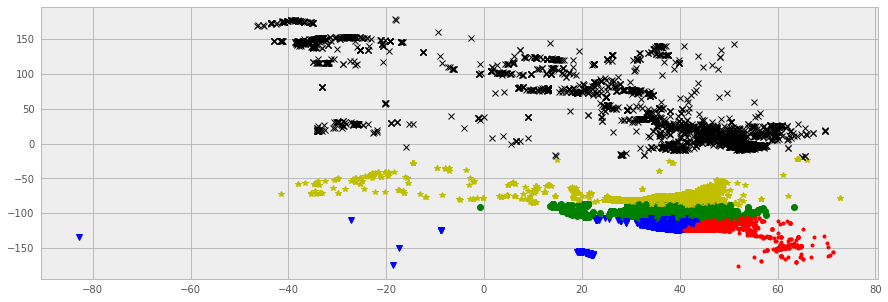

In [13]:
colors = ['r', 'g', 'b', 'y', 'k']
shapes = ['.', 'o', 'v', '*', 'x']
for idx in range(len(locationDataWithLabel)):
    point = plt.plot(locationDataWithLabel[idx][0], locationDataWithLabel[idx][1], shapes[int(locationDataWithLabel[idx][2])]);
    plt.setp(point, color=colors[int(locationDataWithLabel[idx][2])], linewidth=2.0);